<a href="https://colab.research.google.com/github/A3Lab-UNIVPM/DL4SP_notebooks/blob/main/audio_equalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Optimization for FIR fitler design for Audio Equalization

FIR filter optimization for audio equalization using the BiasNet.

In this example, a Single-Input Single-Output (SISO) case is performed.

## Import libraries

In [1]:
### import tensorflow
import tensorflow as tf

### import scipy e numpy
from scipy.io import loadmat  # to load MATLAB .mat files
import numpy as np
from tensorflow.python.keras import backend as K

### import tensorflow API
from tensorflow.keras.models import Sequential,Model   
from tensorflow.keras.layers import Input,Dense, Activation, Flatten, Layer,Conv2D,Lambda,Concatenate,Conv1D,Dropout, Multiply
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

## Download data

In [2]:
# download data
!wget -nc -O IR.zip "https://drive.google.com/uc?export=download&id=1HOj0FSRlBJBGcVxfUO93KGwM79IZvj2y"
!unzip -q IR.zip

--2021-12-31 18:38:01--  https://drive.google.com/uc?export=download&id=1HOj0FSRlBJBGcVxfUO93KGwM79IZvj2y
Resolving drive.google.com (drive.google.com)... 74.125.140.139, 74.125.140.138, 74.125.140.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.140.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-44-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/e8tp5vd72834e3np82aeq4obme11jbsd/1640975850000/14613067190461774444/*/1HOj0FSRlBJBGcVxfUO93KGwM79IZvj2y?e=download [following]
--2021-12-31 18:38:02--  https://doc-08-44-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/e8tp5vd72834e3np82aeq4obme11jbsd/1640975850000/14613067190461774444/*/1HOj0FSRlBJBGcVxfUO93KGwM79IZvj2y?e=download
Resolving doc-08-44-docs.googleusercontent.com (doc-08-44-docs.googleusercontent.com)... 172.253.120.132, 2a00:1450:400c:c01::84
Connecting to doc-08-44-docs.googleusercontent.com (doc-0

## Set the parameters for the optimization

In [4]:
fs=48000   # sampling frequency (Hz)
NFFT=int(np.power(2,np.ceil(np.log2(fs))))  # calculate the NFFT
channel=1  # number of microphones
sources=1  # number of speakers
augment_NFFT=2  # increase the resolution of the NFFT for the frequency convolution

### loading the impulse responses, fs=48000

i=loadmat('IR.mat')
IR=i['s_1_5']  # get the impulse response between the fifth speaker and the first microphone
# with dimensions [number of microphones, number of speakers, length of impulse response]=[1,1,48000]

IR=np.expand_dims(np.expand_dims(IR,0),0) # insert the batch dimension (1)
print(np.shape(IR)) # [1,1,1,48000]

(1, 1, 1, 48000)


## Plot the unequalized amplitude response

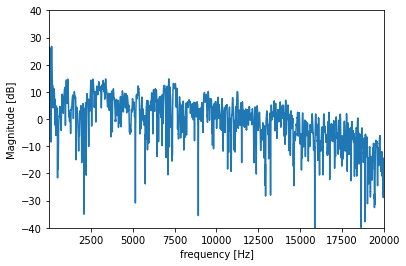

In [5]:
# plot the amplitude response of the impulse response
abs_IR=np.abs(np.fft.fft(IR[0,0,0],NFFT))
freq=np.arange(0,NFFT/2)*fs/NFFT
plt.plot(freq,20*np.log10(abs_IR[0:int(NFFT/2)]))
plt.axis([20 ,20000, -40, 40])
plt.xlabel('frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.show()
epsilon=1e-7 # little value

## Set the neural network parameters

In [ ]:
neurons_dense=[4096,2048,1024,512]  # number of neurons for each Dense Layer
order=8192  # FIR filter order
lenFir=order+1 # number of taps for each filter
iterations=100  #  number of iterations
filters=np.shape(IR)[1]  #  number of filters, equal to the number of the speakers (1 FIR filter for each speaker)
output_parameters=lenFir*filters  # number of parameters of the output layer. They are the coefficients of the FIR filters.
eps_complex=K.constant(tf.cast(tf.complex(1e-30,1e-30),dtype=tf.complex64),dtype=tf.complex64)

IRpadded=tf.pad(IR,K.constant([[0,0],[0,0],[0,0],[0,augment_NFFT*NFFT-fs]],dtype=tf.int32), "CONSTANT")  #  padding for the FFT

Qi=int(50*NFFT/fs)  # minimum frequency of the range to equalize
Qf=int(14000*NFFT/fs)  #  maximum frequency of the range to equalize

lr=0.0001  #  learning rate
filters_array=K.variable(value=np.zeros((1,filters,lenFir)),dtype=tf.float32)  #  array to save the optimized filters by the network
abs_out=K.variable(value=np.zeros((1,channel,int(NFFT/2))),dtype=tf.float32)  #  array to save the frequency response achieved by the simulation

##  definition of the custom activation funciton
def sin_activation(x,w_0=1):
    return tf.math.sin(epsilon+x)+epsilon

tf.keras.activations.sin_activation = sin_activation

# Lambda Layer to reshape the FIR filters from an array to a tensor of dimension [BATCH, number of filters, coefficients]
def filter_layer(inputLayer):
    fir=epsilon+K.reshape(inputLayer[:,0:filters*lenFir],(K.shape(inputLayer)[0],filters,lenFir))
    filters_array.assign(fir)  # save the optimized filters
    return fir

# Lambda Layer for the frequency convolution
def impulse_response(inputLayer):
    fir_new=epsilon+K.reshape(K.tile(inputLayer,(channel,1,1)),(K.shape(inputLayer)[0],channel,sources,lenFir))  # copy the filters according to the number of microphones
    fir_new=tf.cast(tf.pad(fir_new,K.constant([[0,0],[0,0],[0,0],[0,augment_NFFT*NFFT-lenFir]],dtype=tf.int32), "CONSTANT"),dtype=tf.complex64)  # add padding for the FFT
    FIR=tf.signal.fft(fir_new)  #  FFT

    # add dimension to the batch and convert the type of the tensor to comple64
    IR_pad=eps_complex+tf.cast(K.reshape(K.tile(IRpadded,(K.shape(inputLayer)[0],1,1,1)),(K.shape(inputLayer)[0],channel,sources,augment_NFFT*NFFT)),dtype=tf.complex64)
    IR_FFT=tf.signal.fft(IR_pad)

    # frequency convolution
    TEM=IR_FFT*(FIR+eps_complex)+eps_complex
    
    # IFFT
    ntempp=epsilon+tf.cast(tf.math.real(tf.signal.ifft(TEM)),dtype=tf.float32)
    outputLayer=epsilon+K.reshape(ntempp[:,:,:,0:fs],(K.shape(inputLayer)[0],channel,sources,fs))
    return outputLayer

## Lambda layer to sum the filtered impulse responses on speakers
def output_impulse_responses_layer(InputLayer):
    output=epsilon+K.sum(InputLayer+epsilon,axis=2)+epsilon  #[BATCH, microfoni, fs]
    return output


## Lambda layer to get the amplitude response
def fft_layer(inputLayer):
    o=tf.cast(tf.pad(inputLayer,[[0, 0],[ 0, 0],[ 0, int(NFFT-fs)]]),dtype=tf.complex64)
    t3=tf.cast(o,dtype=tf.complex64)
    T=tf.signal.fft(t3)
    T_abs=tf.cast(tf.abs(T[:,:,0:int(NFFT/2)]),dtype=tf.float32)
    abs_out.assign(T_abs)
    return T_abs

## Loss: Euclidean distance between the desired amplitude response and the achieved one by the simulation
def euclidean_distance_magnitude(inputLayer):
    """
    params:
    inputLayer: frequency response
    """
    one_desired=K.ones_like(inputLayer)  ## risposta desiderata 0 dB in scala lineare
    
    euclidean_distance_magnitude=epsilon+K.sum(epsilon+K.sqrt(epsilon+K.sum(epsilon+K.square(one_desired[:,:,Qi:Qf]-inputLayer[:,:,Qi:Qf]),axis=-1)),axis=1,keepdims=True)
    return euclidean_distance_magnitude

## sum the subLoss
def sum_loss(y_true,y_pred):
    return K.sum(y_pred)


## Neural network definition
InputBias=Input(shape=[1])
dense=Dense(neurons_dense[0],activation=sin_activation,kernel_initializer=tf.keras.initializers.RandomUniform(minval=-1e0, maxval=1e0, seed=None),bias_initializer=tf.keras.initializers.RandomUniform(minval=-1e-2, maxval=1e-2, seed=None),use_bias=True)(InputBias)
for i in range(1,len(neurons_dense)):
    dense=Dense(neurons_dense[i],activation=sin_activation,kernel_initializer=tf.keras.initializers.RandomUniform(minval=-1e-2, maxval=1e-2, seed=None))(dense)
fir_layer=Dense(output_parameters,activation=sin_activation,kernel_initializer=tf.keras.initializers.RandomUniform(minval=-1e-2, maxval=1e-2, seed=None))(dense)
filters_layer=Lambda(filter_layer)(fir_layer)
imp_layer=Lambda(impulse_response)(filters_layer)
out_layer=Lambda(output_impulse_responses_layer)(imp_layer)
fft_layer=Lambda(fft_layer)(out_layer)

## definition of the loss function
loss=Lambda(euclidean_distance_magnitude)(fft_layer)
total_loss=Dense(1,use_bias=False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(value=1.0),trainable=False)(loss)

model=Model(inputs=[InputBias],outputs=[total_loss])
optimizer = Adam(learning_rate=lr, decay=1e-4)
model.compile(loss=[sum_loss], optimizer=optimizer)

## Start optimization

epoch: 1 loss: 137.74171447753906
epoch: 2 loss: 132.9613800048828
epoch: 3 loss: 126.70368194580078
epoch: 4 loss: 117.48812103271484
epoch: 5 loss: 106.24266052246094
epoch: 6 loss: 98.37680053710938
epoch: 7 loss: 99.09393310546875
epoch: 8 loss: 91.685546875
epoch: 9 loss: 83.42961120605469
epoch: 10 loss: 80.9712142944336
epoch: 11 loss: 78.46192169189453
epoch: 12 loss: 74.72955322265625
epoch: 13 loss: 71.13082885742188
epoch: 14 loss: 67.61763000488281
epoch: 15 loss: 67.19690704345703
epoch: 16 loss: 66.3160629272461
epoch: 17 loss: 61.82551956176758
epoch: 18 loss: 58.55177307128906
epoch: 19 loss: 58.01103973388672
epoch: 20 loss: 56.167564392089844
epoch: 21 loss: 55.0674934387207
epoch: 22 loss: 51.75802993774414
epoch: 23 loss: 52.96998977661133
epoch: 24 loss: 50.3812141418457
epoch: 25 loss: 49.164119720458984
epoch: 26 loss: 47.16592025756836
epoch: 27 loss: 46.533103942871094
epoch: 28 loss: 45.179996490478516
epoch: 29 loss: 44.955589294433594
epoch: 30 loss: 42.5171

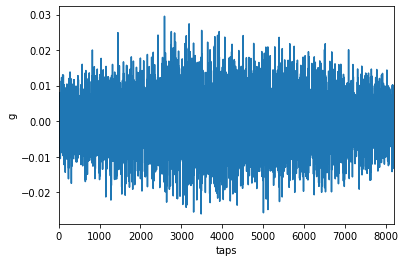

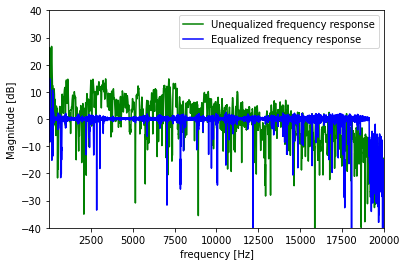

In [7]:
## start the optimization
_loss=1e10
for i in range(iterations):
    # optimize each iteration
    loss=model.train_on_batch([[np.zeros((1))]], [[np.zeros((1))]])    
    if loss<_loss:
      best_fir=K.eval(filters_array) # save best filter coefficients
      best_abs=K.eval(abs_out) # save best frequency response
    print('epoch: '+str(i+1)+' loss: '+str(loss))
print(best_fir)
fir=best_fir[0]
print(fir)
plt.plot(fir[0])
plt.xlabel('taps')
plt.ylabel('g')
plt.xlim(0,lenFir)
plt.show()

plt.plot(freq,20*np.log10(abs_IR[0:int(NFFT/2)]),'g',20*np.log10(best_abs[0,0]),'b')
plt.axis([20,20000,-40,40])
plt.legend(['Unequalized frequency response', 'Equalized frequency response'])
plt.xlabel('frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.show()